In [55]:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sympy
from tqdm import tqdm
from utils import is_extreme_boundary
import plotly
import gmsh

### Load precomputed integrals

In [56]:
lagrange_linear_poisson_matrix = dill.load(
    open("../calculations/hermite_cubic_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../calculations/hermite_cubic_poisson_right_values", "rb")
)

lagrange_linear_poisson_matrix_curvilinear = dill.load(
    open("../calculations/cubic_hermite_weak_form_functional_cubic_hermite", "rb")
)
lagrange_linear_poisson_right_values_curvilinear = dill.load(
    open("../calculations/cubic_hermite_weak_form_right_part_cubic_hermite", "rb")
)

mapping_function_curved = dill.load(
    open("../calculations/cubic_hermite_mapping_function", "rb")
)

mapping_function = dill.load(
    open("../calculations/lagrange_linear_mapping_x", "rb")
)

interpolation_function_curved = dill.load(open("../calculations/cubic_hermite_basis", "rb"))
interpolation_function = dill.load(open("../calculations/hermite_cubic_basis_transformed", "rb"))

### Initialize the domain

### Run triangulation

In [57]:
gmsh.initialize()
gmsh.model.add("tri_mesh")

point_mesh_size = 0.7
point_1 = gmsh.model.geo.addPoint(0, 0, 0, point_mesh_size)
point_2 = gmsh.model.geo.addPoint(1, 0, 0, point_mesh_size)
point_3 = gmsh.model.geo.addPoint(0, 1, 0, point_mesh_size)
point_4 = gmsh.model.geo.addPoint(-1, 0, 0, point_mesh_size)
point_5 = gmsh.model.geo.addPoint(0, -1, 0, point_mesh_size)

# Define circles
arc_1 = gmsh.model.geo.addCircleArc(point_2, point_1, point_3)
arc_2 = gmsh.model.geo.addCircleArc(point_3, point_1, point_4)
arc_3 = gmsh.model.geo.addCircleArc(point_4, point_1, point_5)
arc_4 = gmsh.model.geo.addCircleArc(point_5, point_1, point_2)


circle = gmsh.model.geo.addCurveLoop([arc_1, arc_2, arc_3, arc_4])

plane = gmsh.model.geo.addPlaneSurface([circle])

gmsh.model.geo.synchronize()


physical_group_curves_tag = gmsh.model.addPhysicalGroup(1, [arc_1, arc_2, arc_3, arc_4], name="Boundary curves")
physical_group_surface_tag = gmsh.model.addPhysicalGroup(2, [plane], name="Surface")


gmsh.model.mesh.generate(2)
gmsh.fltk.run()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 60%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000222566s, CPU 0.000325s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000389536s, CPU 0.000403s)
Info    : 26 nodes 53 elements
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTr

In [58]:
boundary_node_tags, boundary_node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, physical_group_curves_tag)
surface_node_tags, points = gmsh.model.mesh.getNodesForPhysicalGroup(2, physical_group_surface_tag)
points = points.reshape(-1, 3)[:, :-1]
boundary_node_tags = boundary_node_tags - 1

element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements()
triangles = [nodes for elem_type, nodes in zip(element_types, element_node_tags) if elem_type == 2][0]
triangles = triangles.reshape(-1, 3).astype(int)
triangles = triangles - 1

vertex_marker_is_boundary = np.zeros(surface_node_tags.shape[0])
vertex_marker_is_boundary[boundary_node_tags] = 1

## Get boundary triangles

In [59]:
is_boundary_triangle = np.zeros(triangles.shape[0])
for pidx in np.where(vertex_marker_is_boundary)[0]:
    mask = np.any(triangles == pidx, axis=-1)
    is_boundary_triangle[mask] += 1

is_boundary_triangle = (is_boundary_triangle >= 2)

### Visualize the triangulation

In [60]:
R = np.array([
    [0, -1],
    [1, 0]
])

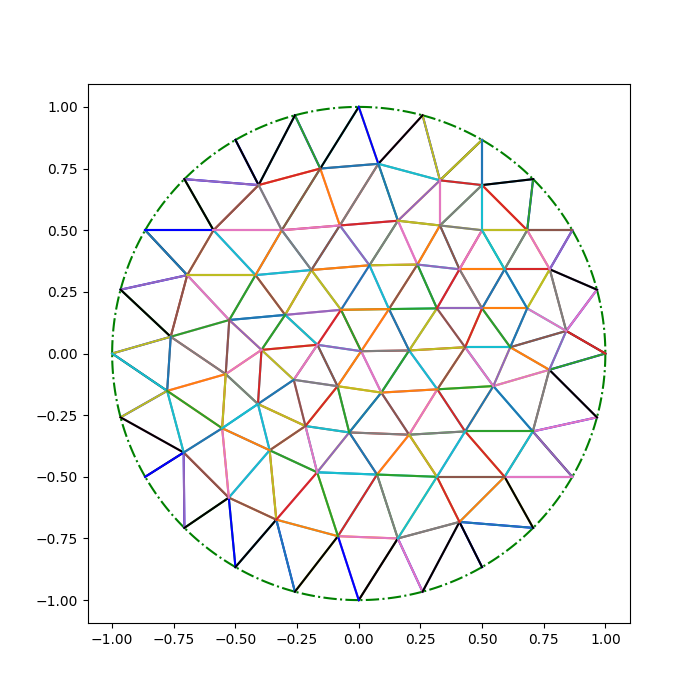

In [61]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")


for tidx, element in enumerate(triangles):
    if is_boundary_triangle[tidx] == True:

        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp

        tt = np.linspace(0, 1, 100)
        pts = points[element]
    
        
        n1 = pts[1] / np.linalg.norm(pts[1])
        n2 = pts[2] / np.linalg.norm(pts[2])
        a = R@n1 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        b = R@n2 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        
        v_22_1 = a[0]
        v_22_2 = a[1]
        
        v_32_1 = -b[0]
        v_32_2 = -b[1]
        

        e1_x, e1_y = mapping_function_curved(tt, 1-tt, pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v_22_1, v_22_2, v_32_1, v_32_2)[:, 0]
        e2_x, e2_y = mapping_function_curved(tt,    0, pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v_22_1, v_22_2, v_32_1, v_32_2)[:, 0]
        e3_x, e3_y = mapping_function_curved(0,    tt, pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v_22_1, v_22_2, v_32_1, v_32_2)[:, 0]

        ax.plot(e1_x, e1_y, color="green", ls="-.")
        ax.plot(e2_x, e2_y, color="black")
        ax.plot(e3_x, e3_y, color="blue")                
    else:
        ax.plot(*points[element[[0, 1]]].T)
        ax.plot(*points[element[[1, 2]]].T)
        ax.plot(*points[element[[0, 2]]].T)
    
plt.show()

In [62]:
x, y = sympy.symbols("x y")

In [63]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)

right_part_values = np.zeros((points.shape[0], 3))
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)

In [64]:
matrix = np.zeros((3* points.shape[0], 3*points.shape[0]))
b = np.zeros(3*points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    if is_boundary_triangle[idx]:
        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp
            
        pts = points[element]

        n1 = pts[1] / np.linalg.norm(pts[1])
        n2 = pts[2] / np.linalg.norm(pts[2])
        aa = R@n1 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        bb = R@n2 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        
        v_22_1 = aa[0]
        v_22_2 = aa[1]
        
        v_32_1 = -bb[0]
        v_32_2 = -bb[1]

        FF = lagrange_linear_poisson_matrix_curvilinear(x1, y1, x2, y2, x3, y3, v_22_1, v_22_2, v_32_1, v_32_2)
        ff = lagrange_linear_poisson_right_values_curvilinear(x1, y1, x2, y2, x3, y3, v_22_1, v_22_2, v_32_1, v_32_2, *right_part_values[element].flatten())
        
    else:
        FF = lagrange_linear_poisson_matrix(x1, y1, x2, y2, x3, y3, )
        ff = lagrange_linear_poisson_right_values(x1, y1, x2, y2, x3, y3, *right_part_values[element].flatten())


    for local_point in range(3):
        if vertex_marker_is_boundary[element[local_point]] == True:
            matrix[3*element[local_point] + 0, 3*element[local_point] + 0] = 1
            matrix[3*element[local_point] + 1, 3*element[local_point] + 1] = 1
            matrix[3*element[local_point] + 2, 3*element[local_point] + 2] = 1

            b[3*element[local_point] + 0] = 0
            b[3*element[local_point] + 1] = 0
            b[3*element[local_point] + 2] = 0
        else:
            for i in range(3):
                for a in range(3):
                    for e in range(3):
                        matrix[3*element[local_point] + a, 3*element[i] + e] += FF[3*local_point + a, 3*i + e]

                b[3*element[local_point] + i] -=  ff[3*local_point + i, 0]

100%|██████████| 144/144 [00:00<00:00, 4660.73it/s]


In [65]:
S = np.linalg.solve(matrix, b)

In [66]:
param = np.linspace(0, 1, 22)
tx, ty = np.meshgrid(param, param, indexing="ij")
mask = ty <= 1 - tx
tx = tx[mask]
ty = ty[mask]

In [67]:
F =  S[0::3]
Fx = S[1::3]
Fy = S[2::3]

In [68]:
XX, YY, ZZ = [], [], []

for idx, element in enumerate(triangles):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]


    if is_boundary_triangle[idx]:
        
        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp
            
        pts = points[element]

        n1 = pts[1] / np.linalg.norm(pts[1])
        n2 = pts[2] / np.linalg.norm(pts[2])
        aa = R@n1 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        bb = R@n2 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        
        
        v_22_1 = aa[0]
        v_22_2 = aa[1]
        
        v_32_1 = -bb[0]
        v_32_2 = -bb[1]

        e1_x, e1_y = mapping_function_curved(tx, ty, 
                                      pts[0, 0], pts[0, 1], 
                                      pts[1, 0], pts[1, 1], 
                                      pts[2, 0], pts[2, 1], 
                                      v_22_1, v_22_2, 
                                      v_32_1, v_32_2)


        XX.append(e1_x.flatten())
        YY.append(e1_y.flatten())
        
        ZZ.append(interpolation_function_curved(tx, ty, 
                                        pts[0, 0], pts[0, 1], 
                                        pts[1, 0], pts[1, 1], 
                                        pts[2, 0], pts[2, 1], 
                                        v_22_1, v_22_2, 
                                        v_32_1, v_32_2,
                                        F[element[0]],
                                        Fx[element[0]],
                                        Fy[element[0]],
                                        F[element[1]],
                                        Fx[element[1]],
                                        Fy[element[1]],
                                        F[element[2]],
                                        Fx[element[2]],
                                        Fy[element[2]],
                                         )
        )
        
    else:
        pts = points[element]

        e1_x, e1_y = mapping_function(tx, ty, 
                                      pts[0, 0], pts[0, 1], 
                                      pts[1, 0], pts[1, 1], 
                                      pts[2, 0], pts[2, 1], 
                                     )


        
        XX.append(e1_x.flatten())
        YY.append(e1_y.flatten())
        
        ZZ.append(interpolation_function(
                                        pts[0, 0], pts[0, 1], 
                                        pts[1, 0], pts[1, 1], 
                                        pts[2, 0], pts[2, 1], 
                                        F[element[0]],
                                        Fx[element[0]],
                                        Fy[element[0]],
                                        F[element[1]],
                                        Fx[element[1]],
                                        Fy[element[1]],
                                        F[element[2]],
                                        Fx[element[2]],
                                        Fy[element[2]],
                                        tx, ty
                                        )
        )

In [69]:
plot_data = [
    plotly.graph_objects.Mesh3d(
                                x=xx,
                                y=yy,
                                z=zz,                                          
                                )    
    for xx, yy, zz in zip(XX, YY, ZZ) 
    ]
fig = plotly.graph_objects.Figure(data=plot_data)
fig.update_layout()


In [70]:
x = np.concatenate(XX)
y = np.concatenate(YY)
z_hat = np.concatenate(ZZ)
z = (x**2 + y**2 - 1)/4

In [71]:
d = z_hat - z

In [72]:
plot_data = [
    plotly.graph_objects.Mesh3d(
                                x=x,
                                y=y,
                                z=d,                                          
                                )    
    ]
fig = plotly.graph_objects.Figure(data=plot_data)
fig.update_layout()
